效用函数$\mu(c)=\frac{c^{1-\gamma}}{1-\gamma}$（CRRA效用函数）,在t期，$k_{t}$表示资本存量，$y_{t}$表示产出，$c_{t}$表示消费量，$i_{t}$表示投资，$\delta$表示资本的损失率，其中$y = f(k) = k^{\alpha},\alpha \in (0,1)$考虑如下一个最优化问题：
$$
 \max_{\{c_{t}\}_{1}^{\infty},\{k_{t}\}_{2}^{\infty}}\sum_{t=1}^{\infty}\beta^{t-1}\mu(c_{t})\\
 s.t.y_{t} = c_{t} + i_{t},k_{t+1} = k_{t}(1-\delta)+i_{t}
$$
求其贝尔曼方程为：$V(k)=\max_{k'} \{\mu(k^\alpha+(1-\delta)k-k')+\beta V(k')\}$,等价于$V(k)=max_{c}\{\mu(c)+\beta V((1-\delta)k+k^{\alpha}-c)\}$，对其进行迭代求解即可。


In [1]:
from __future__ import division 
from scipy.interpolate import InterpolatedUnivariateSpline #一维插值函数
from scipy.optimize import fminbound #求其最小值的函数，返回其最小值点
# from scipy.optimize import curve_fit
import matplotlib.pyplot as plt #绘图
import numpy as np

In [2]:
class CakeProblem(object):
        def __init__(self, beta, delta, gamma, alpha,#初始化
            grid_max=2.5, grid_min = 1e-3, grid_size=250):#grid_max代表蛋糕的尺寸,size代表点集的数量

            self.delta, self.beta, self.gamma ,self.alpha= delta, beta, gamma ,alpha#变量初始化，具体说明见题意
            if  gamma != 1.0:
                self.u = lambda c: (c**(1 - gamma))/(1 - gamma)
            else:
                self.u = np.log# gamma=1时认为u=ln c
                self.gamma = 1
                
            self.grid = np.linspace(grid_min, grid_max, grid_size)#生成插值点
            
        def bellman_operator(self, w):#定义贝尔曼方程，用于后面的迭代求解
            Vx = InterpolatedUnivariateSpline(self.grid, w,k = 5)#对W进行关于grid的一维插值

            Tw = np.empty(len(w))
            c = np.empty(len(w))
            for i, x in enumerate(self.grid):
                value = lambda c: - self.u(c) - self.beta * Vx((1-self.delta)*x - c+x**self.alpha)#定义贝尔曼方程
                c_star = fminbound(value, 0, (1-self.delta)*x+x**self.alpha)#最优化
                Tw[i] = - value(c_star)
                c[i] = c_star

            return Tw,c #返回值包含两个，一个是迭代得到的的值的集合，一个是对应的最优c的值

In [3]:
def compute_fixed_point(T, v, error_tol=1e-3, max_iter=500,#进行迭代的函数，T代表传入的值函数（贝尔曼方程），v代表上次迭代的值，error_tol代表误差范围，max_iter代表最大迭代次数，            
                            print_skip=25,verbose=True):#print_skip代表打印结果的间隔，verbose代表是否打印结果
        i = 0
        error = error_tol + 1

        while i < max_iter and error > error_tol:
            new_v = T(v[0])
            i += 1
            error = np.max(np.abs(new_v[0] - v[0]))
            if verbose and i % print_skip == 0:
                print(f"第 {i}步收敛结果是  {error}.")
                
            v = new_v
        if i == max_iter:
            print("收敛失败")
        if verbose and i < max_iter:
            print(f"\n在第 {i} 步收敛,收敛结果是{error}")


        return v

In [4]:
a = float(input("请输入beta:"))
num1 = input("请输入delta，范围(0，1]：")
while True:
    try:
        b = float(num1)
        if 0 < b <= 1:
            break
        else:
            num1 = input("输入的数不在范围内！请重新输入：")
    except ValueError:
        num1 = input("您输入的不是浮点数！请重新输入：")
c = float(input("请输入gamma:"))
num = input("请输入alpha，范围（0，1]：")
while True:
    try:
        d = float(num)
        if 0 < d <= 1:
            break
        else:
            num = input("输入的数不在范围内！请重新输入：")
    except ValueError:
        num = input("您输入的不是浮点数！请重新输入：")

请输入beta:0.9
请输入delta，范围(0，1]：2
输入的数不在范围内！请重新输入：1
请输入gamma:1
请输入alpha，范围（0，1]：0.7


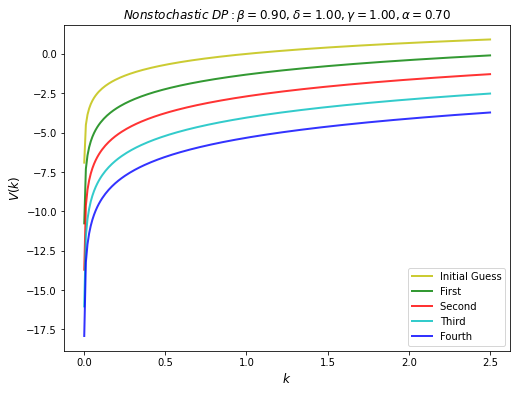

In [5]:
cp = CakeProblem(beta = a,delta = b,gamma = c,alpha = d)
v_zero = np.log(cp.grid)#初始化v的值
v_one = cp.bellman_operator(v_zero)[0] #第一次迭代
v_two = cp.bellman_operator(v_one)[0] #第二次迭代
v_three = cp.bellman_operator(v_two)[0]#第三次迭代
v_four = cp.bellman_operator(v_three)[0]#第四次迭代


fig, ax = plt.subplots(figsize =(8,6))

ax.plot(cp.grid, v_zero, 'y-', lw = 2, alpha = .8, label='Initial Guess')
ax.plot(cp.grid, v_one, 'g-', lw = 2, alpha = .8, label='First ')
ax.plot(cp.grid, v_two, 'r-', lw = 2, alpha = .8, label='Second ')
ax.plot(cp.grid, v_three, 'c-', lw = 2, alpha = .8, label='Third ')
ax.plot(cp.grid, v_four, 'b-', lw = 2, alpha = .8, label='Fourth ')
ax.legend()
ax.set_ylabel('$V(k)$', fontsize=12)
ax.set_xlabel('$k$', fontsize=12)

t = r'$Nonstochastic \ DP:\beta = {0:.2f},\delta = {1:.2f},\gamma = {2:.2f}, \alpha = {3:.2f}$'.format(cp.beta,cp.delta,cp.gamma,cp.alpha)
ax.set_title(t)

plt.show()

In [6]:
v = np.zeros((2,len(cp.grid)))
v_star = compute_fixed_point(cp.bellman_operator, v, max_iter = 500)#对值函数进行迭代

第 25步收敛结果是  0.17730239711015727.
第 50步收敛结果是  0.012724279424688234.
第 75步收敛结果是  0.00091347341875192.

在第 75 步收敛,收敛结果是0.00091347341875192


In [11]:
#使用解析解进行验证
def kkf(x):
    return cp.alpha*cp.beta*x**cp.alpha
def cc(x):
    return (1-cp.alpha*cp.beta)*x**cp.alpha

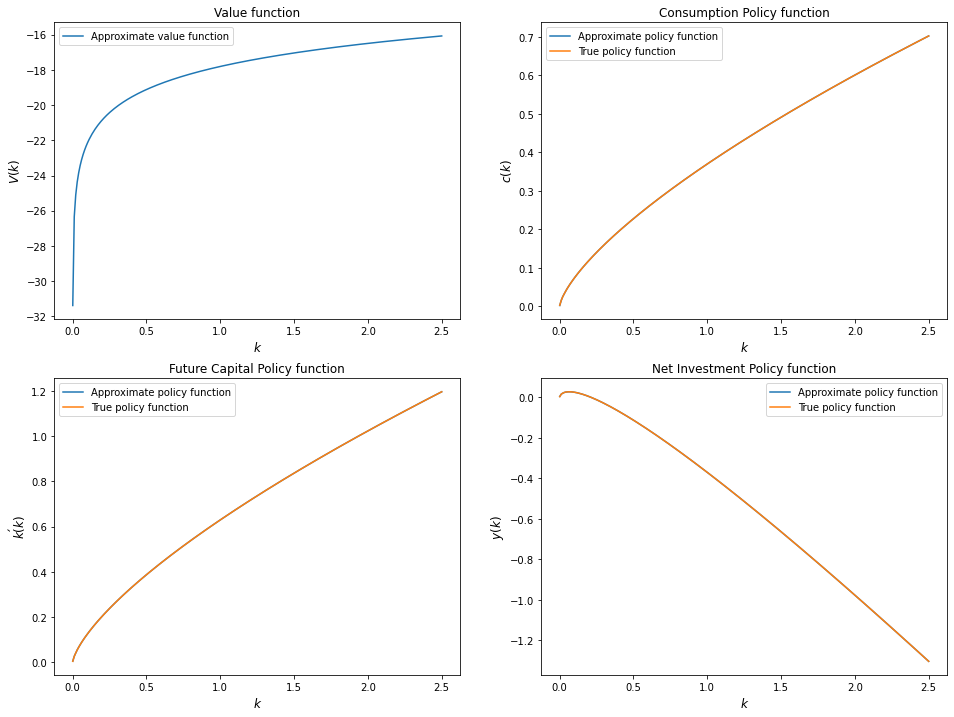

In [17]:
fig = plt.figure(figsize=(16,12))
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)

ax1.plot(cp.grid, v_star[0], label='Approximate value function')#由于是迭代得到的结果，因此结果不能认为使精确的
ax1.set_ylabel('$V(k)$', fontsize=12)
ax1.set_xlabel('$k$', fontsize=12)
ax1.set_title('Value function')
ax1.legend()

c_star = v_star[1]
ax2.plot(cp.grid, c_star, label='Approximate policy function')
ax2.plot(cp.grid, cc(cp.grid),label='True policy function')
# ax2.plot((1-cp.beta*cp.alpha)**(1/(1-cp.alpha)),(1-cp.beta*cp.alpha)**(1/(1-cp.alpha)),'ro')
ax2.set_ylabel(r'$c(k)$', fontsize=12)
ax2.set_xlabel('$k$', fontsize=12)
ax2.legend()
ax2.set_title('Consumption Policy function')

kk = np.empty(len(cp.grid))
y = np.empty(len(cp.grid))
for i, x in enumerate(c_star):
    kk[i] = cp.grid[i]**cp.alpha+(1-cp.delta)*cp.grid[i]-x
    y[i] = kk[i]-cp.grid[i]
    
    

ax3.plot(cp.grid, kk, label='Approximate policy function')
ax3.plot(cp.grid,kkf(cp.grid),label='True policy function')
ax3.set_ylabel(r'$k\'(k)$', fontsize=12)
ax3.set_xlabel('$k$', fontsize=12)
ax3.legend()
ax3.set_title('Future Capital Policy function')


ax4.plot(cp.grid, y, label='Approximate policy function')
ax4.plot(cp.grid,kkf(cp.grid)-cp.grid,label='True policy function')
ax4.set_ylabel(r'$y(k)$', fontsize=12)
ax4.set_xlabel('$k$', fontsize=12)
ax4.legend()
ax4.set_title('Net Investment Policy function')
plt.show()